# Marketing Campaign for Starbucks

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

we are given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

It should be noted that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example case

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# 1 Import Statements

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

from sklearn.preprocessing import LabelEncoder
import seaborn as sns; sns.set(); sns.set(font_scale=1.3)
import matplotlib.pyplot as plt


# 2 Loading Datasets and Inspecting them

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Checking the dataframes

In [3]:
portfolio.head()


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


datatypes of all the dataframes

In [6]:
print(f"portfolio :\n{portfolio.dtypes} \n\nprofile :\n{profile.dtypes}\n\ntranscript :\n{transcript.dtypes}")

portfolio :
channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object 

profile :
age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

transcript :
event     object
person    object
time       int64
value     object
dtype: object


# 3 Cleaning the Data

### 3.1 Cleaning the Transcript DataFrame

The "value" column in transcript DF, needs to be changed as the values are in form of a dictionary, we just need values not the keys. Before that have a closer look at the column

In [7]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [8]:
transcript[transcript.event == 'offer received'].head(3)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}


In [9]:
transcript[transcript.event == 'offer viewed'].head(3)

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
transcript[transcript.event == 'transaction'].head(3)

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}


In [11]:
transcript[transcript.event == 'offer completed'].head(3)

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...


For "value" column we can see that depending of event, the value changes, we will have to split this column into multiple columns and "offer_id" is given as "offer id" with out underscore, we will have check this too!!

We can see that most of the events wont result to a transcation, There are specific events for each and every transcation occured, we can use these later to identify the transcations.

In [12]:
#renaming the "offer id" key to "offer_id"
#we can use dict.pop() to rename dictionary key

for key in transcript.value:
    try:
        key["offer_id"] = key.pop("offer id")
    except:
        pass


In [13]:
#splitting the "value" column into multiple cloumns
value_split = pd.DataFrame(transcript['value'].values.tolist(), index=transcript.index)

#concatenating with original transcript dataframe and dropping the "value" column
transcript_new = pd.concat([transcript, value_split], axis = 1).drop('value', axis = 1)

It should be noted that "value" column in the transcript DF, is same as "id" column in portfolio DF and "person" column in transcript is being referred from profile "id" column, ,so we can rename them accordingly which will make the join operations easy.


**We can create dummies for "event" column**

In [14]:
transcript_new = pd.get_dummies(transcript_new, columns = ['event'])

In [15]:
# renaming the columns to remove space
transcript_new.rename(columns={"event_offer completed":"event_offer_completed",
                           "event_offer received":"event_offer_received",
                          "event_offer viewed":"event_offer_viewed"}, inplace=True)

In [16]:
#renaming the columns of all the Dataframes

portfolio.rename(columns={"id":"offer_id"}, inplace = True)
profile.rename(columns={"id":"customer_id"}, inplace = True)
transcript_new.rename(columns={"person":"customer_id"}, inplace = True)

In [17]:
transcript_new.head()

,customer_id,time,amount,offer_id,reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0


### 3.2 Cleaning the Profile DataFrame 

In [18]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
customer_id         17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


It can be seen that gender fied has some missing values, same number of missing values are there for income

In [19]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
customer_id            0
income              2175
dtype: int64

In [20]:
#checking number of customers present in profile

profile.customer_id.nunique()

17000

In [21]:
transcript_new.head()

,customer_id,time,amount,offer_id,reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0


In [22]:
#checking if all the customers are present in transcript dataframe

len(set(transcript_new.customer_id).intersection(set(profile.customer_id)))

17000

**all the customers are present in the transcript DataFrame**

**Dealing with Missing Values for Profile Dataframe**

In [23]:
profile[profile.gender.isna()].index.values

array([    0,     2,     4, ..., 16989, 16991, 16994])

In [24]:
len(set(profile[profile.income.isna()].index.values).intersection(profile[profile.gender.isna()].index.values))

2175

so we have missing values common for both gender and income, we should further check if we can remove these records completely from the data, or we might have to use some imputation techniques to fill the missing values 

In [25]:
#age of customers who have missing gender and missing income
profile[profile.gender.isna()].age.unique()

array([118])

In [26]:
#checking the customer_ids of customers with missing details
profile[profile.gender.isna()].customer_id.values


array(['68be06ca386d4c31939f3a4f0e3dd783',
       '38fe809add3b4fcf9315a9694bb96ff5',
       'a03223e636434f42ac4c3df47e8bac43', ...,
       'ca45ee1883624304bac1e4c8a114f045',
       'a9a20fa8b5504360beb4e7c8712f8306',
       'c02b10e8752c4d8e9b73f918558531f7'], dtype=object)

In [27]:
profile[profile.customer_id == '68be06ca386d4c31939f3a4f0e3dd783']

,age,became_member_on,gender,customer_id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN


In [28]:
transcript_new[transcript_new.customer_id == '68be06ca386d4c31939f3a4f0e3dd783']

,customer_id,time,amount,offer_id,reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
53174,68be06ca386d4c31939f3a4f0e3dd783,168,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
85290,68be06ca386d4c31939f3a4f0e3dd783,216,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,0,1,0
110828,68be06ca386d4c31939f3a4f0e3dd783,336,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
130147,68be06ca386d4c31939f3a4f0e3dd783,348,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,0,1,0
135224,68be06ca386d4c31939f3a4f0e3dd783,360,0.35,NaN,NaN,0,0,0,1
150596,68be06ca386d4c31939f3a4f0e3dd783,408,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
163374,68be06ca386d4c31939f3a4f0e3dd783,408,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,0,1,0
167626,68be06ca386d4c31939f3a4f0e3dd783,414,0.74,NaN,NaN,0,0,0,1
182544,68be06ca386d4c31939f3a4f0e3dd783,444,1.89,NaN,NaN,0,0,0,1
201570,68be06ca386d4c31939f3a4f0e3dd783,504,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,0,1,0,0


In [29]:
profile[profile.customer_id == '38fe809add3b4fcf9315a9694bb96ff5']

,age,became_member_on,gender,customer_id,income
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN


In [30]:
transcript_new[transcript_new.customer_id == '38fe809add3b4fcf9315a9694bb96ff5']

,customer_id,time,amount,offer_id,reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
47581,38fe809add3b4fcf9315a9694bb96ff5,132,1.34,NaN,NaN,0,0,0,1
53175,38fe809add3b4fcf9315a9694bb96ff5,168,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
65843,38fe809add3b4fcf9315a9694bb96ff5,168,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1,0
130148,38fe809add3b4fcf9315a9694bb96ff5,348,1.64,NaN,NaN,0,0,0,1
184911,38fe809add3b4fcf9315a9694bb96ff5,450,3.47,NaN,NaN,0,0,0,1
193184,38fe809add3b4fcf9315a9694bb96ff5,474,1.62,NaN,NaN,0,0,0,1
245123,38fe809add3b4fcf9315a9694bb96ff5,576,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,1,0,0
285920,38fe809add3b4fcf9315a9694bb96ff5,636,2.14,NaN,NaN,0,0,0,1
294714,38fe809add3b4fcf9315a9694bb96ff5,666,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,0,1,0
301916,38fe809add3b4fcf9315a9694bb96ff5,696,4.09,NaN,NaN,0,0,0,1


In the above cells I have checked if there is any signifiance for the users with missing values. It looks like the users have made transactions also, so they are definetly useful for our further analysis.

It must be that these users do not provide information like age, gender and income while becoming a member, so we will have to use some imputation techniques to fill in these details, we cannot do much with gender, but lets try to fill in details of income and we can figure out what can done with age, as every user with these missing values has an age of 118, which doesnot make sense.

In [31]:
profile.head()

,age,became_member_on,gender,customer_id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Lets deal with the became_member_on column

In [32]:
#changing the column name and converting it into datetime type, which gives us flexibity in understanding the dates

profile['member_since'] = profile['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

#spltting the member_since column into 3 columns, which will help in ananlysis

profile[['start_year','start_month','start_day']] = profile['member_since'].apply(lambda x :pd.Series(x.strftime("%Y,%m,%d").split(",")))


#dropping the became_member_on column

profile = profile.drop('became_member_on' ,axis= 1)



In [33]:
#check the modified dataframe
profile.head()

,age,gender,customer_id,income,member_since,start_year,start_month,start_day
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,2017,02,12
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,2017,07,15
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,2018,07,12
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,2017,05,09
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,2017,08,04


In [34]:
# checking the mean and median values of the profile income column
print(f" Mean :{profile.income.mean()}, Median : {profile.income.median()}")

 Mean :65404.9915682968, Median : 64000.0


We can use one of these values to fill in the missing values, but as per income is concerned depending on the year, people generally get paid more, on that basis i did not want to directly use mean of the whole dataset.

Instead i want to calculate average income for every year and fill in the missing values with the income value for that respective year.

In [35]:
#grouping by year and checkin the mean value
pd.DataFrame(profile.groupby(['start_year'])['income'].mean())

,income
start_year,
2013,57664.233577
2014,58200.906344
2015,67072.010019
2016,70592.592593
2017,65685.479550
2018,61853.638594


Here we can see average income for that particular year, so we can use these values to fill in the icome column checking the start_year

In [36]:
#using the values from above to fill in the missing values of income
profile['income'] = profile.apply(
                        lambda row : 57664 if np.isnan(row['income']) and row['start_year'] == '2013' 
                                    else 58200 if np.isnan(row['income']) and row['start_year'] == '2014'
                                    else 67072 if np.isnan(row['income']) and row['start_year'] == '2015'
                                    else 70592 if np.isnan(row['income']) and row['start_year'] == '2016'
                                    else 65685 if np.isnan(row['income']) and row['start_year'] == '2017'
                                    else 61853 if np.isnan(row['income']) and row['start_year'] == '2018'
                                    else row['income'],
                                    axis = 1) 

In [37]:
#I cannot do much with age and gender columns so just leaving then as it is

profile['gender'].fillna('NA', inplace=True)

In [38]:
profile.head()

,age,gender,customer_id,income,member_since,start_year,start_month,start_day
0,118,NA,68be06ca386d4c31939f3a4f0e3dd783,65685.0,2017-02-12,2017,02,12
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,2017,07,15
2,118,NA,38fe809add3b4fcf9315a9694bb96ff5,61853.0,2018-07-12,2018,07,12
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,2017,05,09
4,118,NA,a03223e636434f42ac4c3df47e8bac43,65685.0,2017-08-04,2017,08,04


In [39]:
profile.age.mean()

62.531411764705879

### 3.3 Cleaning the portfolio DataFrame 

In [40]:
portfolio

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [41]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_id      10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


This dataframe looks cleaner, but we can split the channels column and create dummies for each value.

In [42]:
#we neeed to have unique channels available
all_channels = set()
for channels in portfolio.channels:
    all_channels.update(set(channels))

In [43]:
for channel in all_channels:
    #create a new column for each channel
    portfolio[channel] = portfolio.channels.apply(lambda x : channel in x).map({True : 1, False : 0})

In [44]:
portfolio.drop('channels', axis = 1, inplace = True)

In [45]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,social,mobile,email,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1


### 3.4  Merging The DataFrames

In [46]:
# merging Transcript and profile Dataframe, on common column "customer_id"

transcript_new = transcript_new.merge(profile, on = ['customer_id'])

In [47]:
transcript_new.head()

,customer_id,time,amount,offer_id,reward,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,age,gender,income,member_since,start_year,start_month,start_day
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,75,F,100000.0,2017-05-09,2017,05,09
1,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1,0,75,F,100000.0,2017-05-09,2017,05,09
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,NaN,0,0,0,1,75,F,100000.0,2017-05-09,2017,05,09
3,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,0,75,F,100000.0,2017-05-09,2017,05,09
4,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,NaN,0,0,0,1,75,F,100000.0,2017-05-09,2017,05,09


In [48]:
# we can use left join to have all the offer_ids available in the dataframe
#meging transcript_new with portfolio
transcript_new = transcript_new.merge(portfolio, on=['offer_id'], how='left')

In [49]:
transcript_new.head()

,customer_id,time,amount,offer_id,reward_x,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,age,...,start_month,start_day,difficulty,duration,offer_type,reward_y,social,mobile,email,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,75,...,05,09,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1,0,75,...,05,09,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,NaN,0,0,0,1,75,...,05,09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,0,75,...,05,09,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,NaN,0,0,0,1,75,...,05,09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.5 Encoding the Data

Now if you can see customer_id and offer_id has values which makes to difficult to understand, instead we can map them to some numeric values, which will be helpful.

We can use label encoding for oofer_id, offer_type, gender columns. while we need to have a function for customer_id mapping

In [50]:
#getting the offer_id labels from portflio and using htem to encode our main dataframe
offer_id_labels = LabelEncoder()
offer_id_labels.fit(portfolio.offer_id)
transcript_new['offer_id'] = offer_id_labels.fit_transform(transcript_new['offer_id'].astype(str))

In [51]:
#getting the offer_type labels from portflio and using htem to encode our main dataframe
offer_type_labels = LabelEncoder()
offer_type_labels.fit(portfolio.offer_type)
transcript_new['offer_type'] = offer_type_labels.fit_transform(transcript_new['offer_type'].astype(str))

In [52]:
#getting the gender labels from profile and using htem to encode our main dataframe
gender_labels = LabelEncoder()
gender_labels.fit(profile.gender)
transcript_new['gender'] = gender_labels.fit_transform(transcript_new['gender'].astype(str))

In [53]:
# creating a map function to label the customers in the dataframe
def customer_id_mapper():
    '''
    Run this cell to map the customer_id to a 
    numeric values and remove the the actual customer_id column
    '''
    coded_dict = dict()
    cter = 1
    customer_id_encoded = []
    
    for val in transcript_new['customer_id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        customer_id_encoded.append(coded_dict[val])
    return customer_id_encoded

customer_id_encoded = customer_id_mapper()
del transcript_new['customer_id']
transcript_new['customer_id'] = customer_id_encoded

# show header
transcript_new.head()

,time,amount,offer_id,reward_x,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,age,gender,...,start_day,difficulty,duration,offer_type,reward_y,social,mobile,email,web,customer_id
0,0,NaN,6,NaN,0,1,0,0,75,0,...,09,5.0,7.0,0,5.0,0.0,1.0,1.0,1.0,1
1,6,NaN,6,NaN,0,0,1,0,75,0,...,09,5.0,7.0,0,5.0,0.0,1.0,1.0,1.0,1
2,132,19.89,10,NaN,0,0,0,1,75,0,...,09,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,1
3,132,NaN,6,5.0,1,0,0,0,75,0,...,09,5.0,7.0,0,5.0,0.0,1.0,1.0,1.0,1
4,144,17.78,10,NaN,0,0,0,1,75,0,...,09,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,1


### 3.6 Dividing the Dataframe into transactions and offers


In [54]:
# transactions is a dataframe which consists only of transaction events
transactions = transcript_new[transcript_new['event_transaction']==1]

In [55]:
# offers_df is a dataframe which consists only of offer events
offers = transcript_new[transcript_new['event_transaction']!=1]

Now we have two different dataframes, which gives us completely different information, Lets Explore each of them.

**3.6.1 transcations Dataframe**

In [56]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138953 entries, 2 to 306533
Data columns (total 24 columns):
time                     138953 non-null int64
amount                   138953 non-null float64
offer_id                 138953 non-null int64
reward_x                 0 non-null float64
event_offer_completed    138953 non-null uint8
event_offer_received     138953 non-null uint8
event_offer_viewed       138953 non-null uint8
event_transaction        138953 non-null uint8
age                      138953 non-null int64
gender                   138953 non-null int64
income                   138953 non-null float64
member_since             138953 non-null datetime64[ns]
start_year               138953 non-null object
start_month              138953 non-null object
start_day                138953 non-null object
difficulty               0 non-null float64
duration                 0 non-null float64
offer_type               138953 non-null int64
reward_y                 0 non-null 

It can be seen that there are some columns which has full null values, we can remove the complete column.


In [57]:
#creating column list that can be dropped
col_to_delete = ['time','reward_x','difficulty', 'duration',
                 'reward_y','email', 'social','web', 'mobile']

In [58]:
# resetting the indices
transactions.reset_index(inplace=True)

#removing these columns
for col in col_to_delete:
    del transactions[col]
    
#removing the index column    
del transactions['index']

transactions.head()

,amount,offer_id,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,age,gender,income,member_since,start_year,start_month,start_day,offer_type,customer_id
0,19.89,10,0,0,0,1,75,0,100000.0,2017-05-09,2017,05,09,3,1
1,17.78,10,0,0,0,1,75,0,100000.0,2017-05-09,2017,05,09,3,1
2,19.67,10,0,0,0,1,75,0,100000.0,2017-05-09,2017,05,09,3,1
3,29.72,10,0,0,0,1,75,0,100000.0,2017-05-09,2017,05,09,3,1
4,23.93,10,0,0,0,1,75,0,100000.0,2017-05-09,2017,05,09,3,1


**3.6.2 offers DataFrame**

In [59]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306532
Data columns (total 24 columns):
time                     167581 non-null int64
amount                   0 non-null float64
offer_id                 167581 non-null int64
reward_x                 33579 non-null float64
event_offer_completed    167581 non-null uint8
event_offer_received     167581 non-null uint8
event_offer_viewed       167581 non-null uint8
event_transaction        167581 non-null uint8
age                      167581 non-null int64
gender                   167581 non-null int64
income                   167581 non-null float64
member_since             167581 non-null datetime64[ns]
start_year               167581 non-null object
start_month              167581 non-null object
start_day                167581 non-null object
difficulty               167581 non-null float64
duration                 167581 non-null float64
offer_type               167581 non-null int64
reward_y                 16

only "amount" column has a column of missing values, even event_transaction column does not makes sense in this dataframe as we have only offers in this data, so we can remove that column.

"reward_x" column has many missing values, so I will be removing the complete column

In [60]:
col_to_delete_offers = ['amount', 'event_transaction', 'reward_x']

In [61]:
# resetting the indices
offers.reset_index(inplace=True)

#removing these columns
for col in col_to_delete_offers:
    del offers[col]
    
#removing the index column    
del offers['index']

offers.head()

,time,offer_id,event_offer_completed,event_offer_received,event_offer_viewed,age,gender,income,member_since,start_year,...,start_day,difficulty,duration,offer_type,reward_y,social,mobile,email,web,customer_id
0,0,6,0,1,0,75,0,100000.0,2017-05-09,2017,...,09,5.0,7.0,0,5.0,0.0,1.0,1.0,1.0,1
1,6,6,0,0,1,75,0,100000.0,2017-05-09,2017,...,09,5.0,7.0,0,5.0,0.0,1.0,1.0,1.0,1
2,132,6,1,0,0,75,0,100000.0,2017-05-09,2017,...,09,5.0,7.0,0,5.0,0.0,1.0,1.0,1.0,1
3,168,5,0,1,0,75,0,100000.0,2017-05-09,2017,...,09,0.0,3.0,2,0.0,1.0,1.0,1.0,0.0,1
4,216,5,0,0,1,75,0,100000.0,2017-05-09,2017,...,09,0.0,3.0,2,0.0,1.0,1.0,1.0,0.0,1


Now we have our Data cleaned and we have 2 different data frames to look into the Exploratory Data Analysis

### 3.7 Removing Outliers only for Regression

In [62]:
#getting numeric columns, to remove outliers before we do regression
numerical_columns = transactions.select_dtypes(include=[np.number]).columns
numerical_columns

Index(['amount', 'offer_id', 'event_offer_completed', 'event_offer_received',
       'event_offer_viewed', 'event_transaction', 'age', 'gender', 'income',
       'offer_type', 'customer_id'],
      dtype='object')

In [63]:
# creating a new dataframe, which can be used for our regression
df_reg = transactions
for column in numerical_columns:
    before = df_reg.shape[0]
    _75th = np.percentile(df_reg[column], 75)
    _25th = np.percentile(df_reg[column], 25)
    iqr = _75th - _25th
    df_reg.drop(df_reg[df_reg[column] < _25th - (1.5 * iqr)].index, inplace=True)
    df_reg.drop(df_reg[df_reg[column] > _75th + (1.5 * iqr)].index, inplace=True)
    count = str(before - df_reg.shape[0])
    print("Number of outliers removed in column '{0}' : {1}".format(column, count))
df_reg.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Number of outliers removed in column 'amount' : 1236
Number of outliers removed in column 'offer_id' : 0
Number of outliers removed in column 'event_offer_completed' : 0
Number of outliers removed in column 'event_offer_received' : 0
Number of outliers removed in column 'event_offer_viewed' : 0
Number of outliers removed in column 'event_transaction' : 0
Number of outliers removed in column 'age' : 14925
Number of outliers removed in column 'gender' : 1772
Number of outliers removed in column 'income' : 1238
Number of outliers removed in column 'offer_type' : 0
Number of outliers removed in column 'customer_id' : 0


(119782, 15)

# 4 EXPLORATORY DATA ANALYSIS

#### 4.1 which offers were completed by the user?


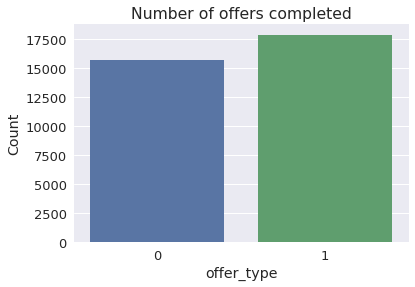

In [105]:
offers_count = offers[offers.event_offer_completed == 1]

sns.countplot(x=offers_count['offer_type'])
plt.title('Number of offers completed')
plt.ylabel('Count')
plt.show();

**It should be seen that BOGO and Discount are the only offers that are completed by the customers**

#### 4.2 What are the most common Offer Type Viewed?

In [106]:
offers_viewed = offers[offers.event_offer_viewed == 1]

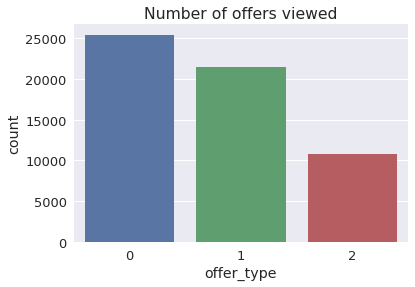

In [107]:
sns.countplot(x=offers_viewed['offer_type'])
plt.title('Number of offers viewed')
plt.ylabel('count')
plt.show();

**Again, Buy One Get One (category 0) is the most viewed offer. It looks like customers are more interested in BOGO Offers. Next most viewed offeris Discount offers and as it can be expected people are least bothered to view informational offers.**

#### 4.3 What are the most common offers viewed?

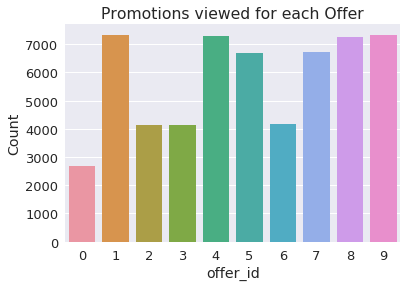

In [110]:
sns.countplot(x=offers_viewed['offer_id'])
plt.title('Promotions viewed for each Offer')
plt.ylabel('Count')
plt.show();

**Offer Ids 1,4,8,9 are most viewed and these belong to BOGO and Discount types**

#### 4.4 Which gender group are viewing the offers?

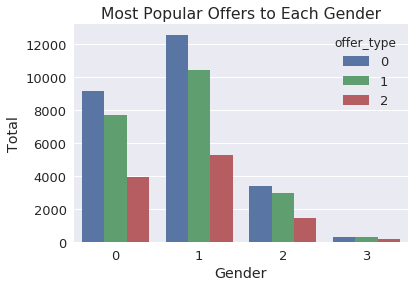

In [115]:
sns.countplot(x=offers_viewed['gender'], hue = 'offer_type', data=offers_viewed)
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.show();

**Males are viewing the offers mostly and popular one out of the viewed offers is again BOGO. It can also be seen that Informational offers are not popular as compared to other offer types**

#### 4.5 which gender group are transcating more?

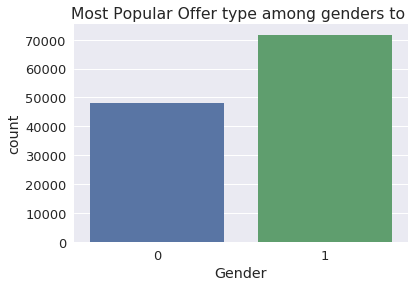

In [140]:
sns.countplot(x=transactions['gender'])
plt.title('Most Popular Offer type among genders to ')
plt.ylabel('count')
plt.xlabel('Gender')
plt.show();

**Looks like Males are transcating more**

#### 4.6 Which age group is spending more?

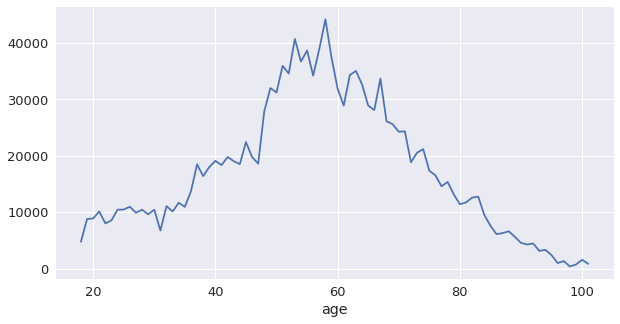

In [133]:
fig, ax = plt.subplots(figsize=(10,5))
transactions.groupby(['age']).sum()['amount'].plot(ax=ax)

**Age group between 50 - 60 are spending more**

#### 4.7 How is income related with the amount being spent ?

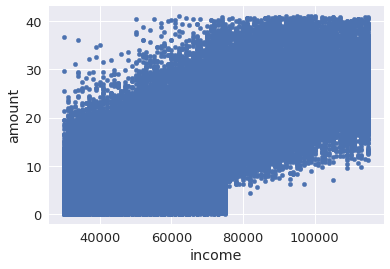

In [147]:
transactions.plot.scatter(x='income', y = 'amount')

**there is a linear relation for the income and amount**

#### 4.8 How many Number of sign ups happening each day?

In [151]:
transcript_new.head()

,time,amount,offer_id,reward_x,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,age,gender,...,start_day,difficulty,duration,offer_type,reward_y,social,mobile,email,web,customer_id
0,0,NaN,6,NaN,0,1,0,0,75,0,...,09,5.0,7.0,0,5.0,0.0,1.0,1.0,1.0,1
1,6,NaN,6,NaN,0,0,1,0,75,0,...,09,5.0,7.0,0,5.0,0.0,1.0,1.0,1.0,1
2,132,19.89,10,NaN,0,0,0,1,75,0,...,09,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,1
3,132,NaN,6,5.0,1,0,0,0,75,0,...,09,5.0,7.0,0,5.0,0.0,1.0,1.0,1.0,1
4,144,17.78,10,NaN,0,0,0,1,75,0,...,09,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,1


Text(0.5,1,'Number of Sign Ups Each Year')

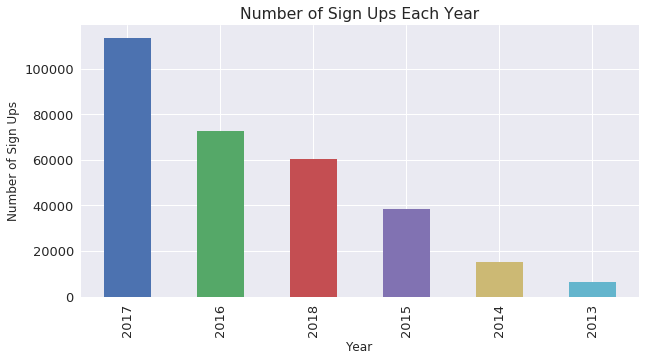

In [158]:
transcript_new.start_year.value_counts().plot(kind = 'bar', figsize = (10,5))
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Number of Sign Ups', fontsize = 12)
plt.title('Number of Sign Ups Each Year')

**It can be seen that there were many sign Ups in 2017, while in 2018 the number went down!!**

#### 4.9 How is amount values Distributed?

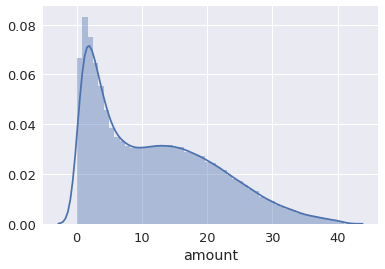

In [160]:
sns.distplot(transactions['amount'])

# 5 MACHINE LEARNING MODELS - 

## REGRESSION

**Building a machine learning model that predicts how much someone will spend based on demographics and offer type**


In [71]:
profile.columns

Index(['age', 'gender', 'customer_id', 'income', 'member_since', 'start_year',
       'start_month', 'start_day'],
      dtype='object')

In [72]:
offers.columns

Index(['time', 'offer_id', 'event_offer_completed', 'event_offer_received',
       'event_offer_viewed', 'age', 'gender', 'income', 'member_since',
       'start_year', 'start_month', 'start_day', 'difficulty', 'duration',
       'offer_type', 'reward_y', 'social', 'mobile', 'email', 'web',
       'customer_id'],
      dtype='object')

Lets Take the transactions DataFrame and Try to predict the amount that will be spent by user. This will be supervised learning Regression technique

In [73]:
transactions.head()

,amount,offer_id,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,age,gender,income,member_since,start_year,start_month,start_day,offer_type,customer_id
0,19.89,10,0,0,0,1,75,0,100000.0,2017-05-09,2017,05,09,3,1
1,17.78,10,0,0,0,1,75,0,100000.0,2017-05-09,2017,05,09,3,1
2,19.67,10,0,0,0,1,75,0,100000.0,2017-05-09,2017,05,09,3,1
3,29.72,10,0,0,0,1,75,0,100000.0,2017-05-09,2017,05,09,3,1
4,23.93,10,0,0,0,1,75,0,100000.0,2017-05-09,2017,05,09,3,1


In [74]:
#dividing the data into features and target, you can ad  other features also
X = df_reg[['offer_id','age','gender','income','offer_type']]
y = df_reg[['amount']]

### 5.1 Linear Regression

In [75]:
# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import	cross_val_score

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.3, random_state=100)

# Create the regressor: reg
reg = LinearRegression()

# Fit the regressor to the training data
reg.fit(X_train_reg,y_train_reg)

# Predict on the test data: y_pred
y_pred = reg.predict(X_test_reg)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg.score(X_test_reg, y_test_reg)))
rmse = np.sqrt(mean_squared_error(y_test_reg,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.4831234226547428
Root Mean Squared Error: 6.689900461262733


we have an R2 of 0.48 which is decent, lets look at other models

#### 5.1.1 OLS Model Summary

In [76]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [77]:
X_train_reg = sm.add_constant(X_train_reg) ## let's add an intercept (beta_0) to our model
model = OLS(endog=y_train_reg, exog=X_train_reg)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                 2.655e+04
Date:                Wed, 22 Apr 2020   Prob (F-statistic):               0.00
Time:                        03:41:36   Log-Likelihood:            -2.7821e+05
No. Observations:               83847   AIC:                         5.564e+05
Df Residuals:                   83843   BIC:                         5.565e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
offer_id      -0.5973      0.009    -64.064      0.000      -0.616      -0.579
age            0.0384      0.001     28.611      0.000       0.036       0.041
gender        -2.7324      0.048    -56.771      0.000      -2.827      -2.638
income         0.0003   1.23e-06    242.208      0.000       0.000       0.000
offer_type    -0.1792      0.003    -64.064      0.000      -0.185      -0.174
==============================================================================
Omnibus:                     1609.207   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1702.939
Skew:                           0.348   Prob(JB):                         0.00
Kurtosis:                       3.056   Cond. No.                     3.07e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.66e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [78]:
#important features that are effecting the target
model_fit.params.sort_values(ascending=False)

age           0.038375
income        0.000297
offer_type   -0.179190
offer_id     -0.597301
gender       -2.732424
dtype: float64

In [79]:
y_pred_test = model_fit.predict(X_test_reg)

In [80]:
y_test_reg.amount.shape

(35935,)

In [81]:
y_pred_test.shape

(35935,)

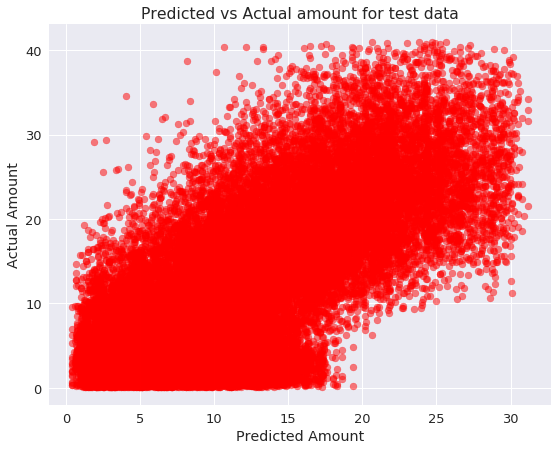

In [82]:
#plotting our results
plt.figure(figsize=(9,7))
plt.scatter(y_pred_test, y_test_reg.amount, alpha=0.5, c='r')
plt.title('Predicted vs Actual amount for test data')
plt.xlabel('Predicted Amount')
plt.ylabel('Actual Amount')
axes = plt.gca()
plt.show();

### 5.2 Decision Tree Regressor

In [83]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
# Instantiate dt
dt = DecisionTreeRegressor(max_depth=8,
                           min_samples_leaf=0.13,
                           random_state=100)

params_dt = {
    'max_depth': [3, 4,5, 6],
    'min_samples_leaf': [0.04, 0.06, 0.08],
    'max_features': [0.2, 0.4,0.6, 0.8]
}

grid_dt = GridSearchCV(estimator=dt, param_grid=params_dt, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

# Fit 'dt' to the training-set
grid_dt.fit(X_train_reg, y_train_reg)

# Predict test-set labels
y_pred_reg_dt = grid_dt.predict(X_test_reg)
    
# Compute test-set MSE
mse_dt =  MSE(y_test_reg, y_pred_reg_dt)

# Compute test-set RMSE 
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print(rmse_dt)

6.4723012134


We have almost similar results for Decision Tree and Linear regression, so we ca use any one the above models to predict the amount that will be spent by the user based on his data we already have.

# 6 Machine Learning Models - 

# Classification

**Another Machine Learning model to personalize offer_type for each customer, which can help in sending the personalized offer.**

In [84]:
#creating our data
X_clf = offers.drop(['offer_type', 'customer_id', 'offer_id','member_since'], axis=1)
y_clf = offers['offer_type']


In [85]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, random_state=100)

**checking if we have right distribution of classes for both train and test datasets**

In [86]:
def classes_percent(df):
    table = df.value_counts().sort_index()
    print('Class ' + str(table.index[0]) + ' : '+ str(round(table[0]/sum(table)*100,0))+'%')
    print('Class ' + str(table.index[1]) + ' : '+ str(round(table[1]/sum(table)*100,0))+'%')
    print('Class ' + str(table.index[2]) + ' : '+ str(round(table[1]/sum(table)*100,0))+'%')

In [87]:
print('Distribution of classes in Training Data :')
classes_percent(y_train)

print('Distribution of classes in Test Data :')
classes_percent(y_test)

Distribution of classes in Training Data :
Class 0 : 43.0%
Class 1 : 42.0%
Class 2 : 42.0%
Distribution of classes in Test Data :
Class 0 : 43.0%
Class 1 : 42.0%
Class 2 : 42.0%


In [88]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)


Training Features Shape: (125685, 17)
Training Labels Shape: (125685,)
Testing Features Shape: (41896, 17)
Testing Labels Shape: (41896,)


### 6.1 Logistic Regression using GridSearch CV


In [89]:
# Import the necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
# Larger c means less regularization. Smaller c means higher regularization.
# Regularization is an extra term added to the original loss function. Penalizes large value of coefficients.
# Hence training accuracy is decreased but improves test accuracy 
# since large coefficients that are overfitting the model is reduced. 

c_space = np.logspace(-5, 8, 15) # 15 values between e~-5 to e^+8
param_grid = {'C' : c_space,
             'penalty' : ['l1', 'l2']}

# Create the classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the classifier to the training data
logreg_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 1.0000000000000001e-05, 'penalty': 'l2'}
Best score is 1.0


In [90]:
prob = logreg_cv.predict_proba(X_clf)
print("Maximum predicted probability\n", prob[:5])

Maximum predicted probability
 [[ 0.64538565  0.23492643  0.11968791]
 [ 0.64598076  0.23505431  0.11896493]
 [ 0.64611353  0.23958056  0.11430591]
 [ 0.21813398  0.10533149  0.67653453]
 [ 0.21939937  0.10618009  0.67442054]]


In [91]:
# Create the classifier: logreg
logreg = LogisticRegression(**logreg_cv.best_params_)

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred_logit = logreg.predict(X_test)

Confusion Matrix

In [92]:
# Evaluating the performance of Test data using Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_logit))
print(classification_report(y_test, y_pred_logit))

[[17847     0     0]
 [    0 17529     0]
 [    0     0  6520]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17847
          1       1.00      1.00      1.00     17529
          2       1.00      1.00      1.00      6520

avg / total       1.00      1.00      1.00     41896



**A pure case of overfitting, our model is trying hard to learn the features and it has overfitted on our data, which will be likely to break if we use other new data, so it would be better if we use other techniques to understand the data better**

## 6.2  k - Nearest Neighbors (kNN)

In [93]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = np.arange(1, 15)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

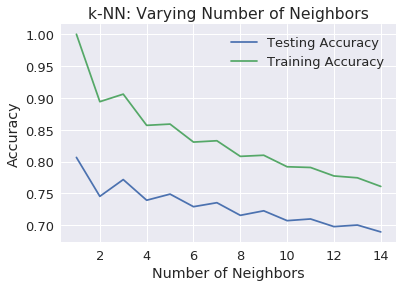

In [94]:
# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [95]:
knn_results = pd.DataFrame(data={ 
             'train_accuracy' : train_accuracy, 
             'test_accu racy' : test_accuracy,
            'difference' : test_accuracy-train_accuracy},
             index=neighbors).sort_values(['difference'], ascending=False)
knn_results

,train_accuracy,test_accuracy,difference
14,0.760958,0.689517,-0.071441
13,0.774516,0.700306,-0.074210
12,0.777404,0.697847,-0.079557
11,0.790731,0.709853,-0.080878
10,0.791853,0.707204,-0.084649
9,0.809945,0.722670,-0.087275
8,0.808187,0.715558,-0.092630
7,0.832701,0.735392,-0.097308
6,0.830632,0.729139,-0.101493
5,0.858877,0.748902,-0.109975


In [96]:
# Create a k-NN classifier with 14 neighbors since the difference between train and test accuracy is minimum
knn = KNeighborsClassifier(n_neighbors=7)

# Fit the classifier to the data
knn.fit(X_train, y_train)

# Predict the labels for the test data
y_pred_knn = knn.predict(X_test)

In [97]:
 # Evaluating the performance of Test data using Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)
cm

array([[14120,  3576,   151],
       [ 4606, 12869,    54],
       [ 1776,   923,  3821]])

In [98]:
print(classification_report(y_test, y_pred_knn))

             precision    recall  f1-score   support

          0       0.69      0.79      0.74     17847
          1       0.74      0.73      0.74     17529
          2       0.95      0.59      0.72      6520

avg / total       0.75      0.74      0.74     41896



[Text(73.2,0.5,'Actual'), Text(0.5,66,'Predicted')]

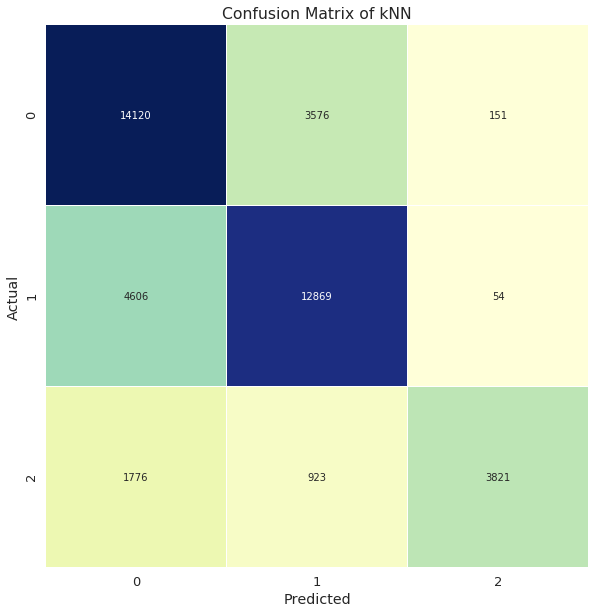

In [99]:
# Plotting the Confusion Matrix for each understanding
fig, ax = plt.subplots(figsize=(10,10))
# plt.figure(figsize=(9,7))
# ax = plt.axes()
sns.heatmap(cm,
            annot=True, # Show values of each cell in the heatmap
            fmt="1.0f", # or "d"
            cmap="YlGnBu", # color range of the heatmap
            linecolor='white', # plot cell border
            linewidths=0.1, # width of border
            cbar=False, # hide range bar
            square=True) # Make the Confusion Matrix Look like a square
ax.set_title('Confusion Matrix of kNN')
ax.set(xlabel='Predicted', ylabel='Actual') # Change X and Y axis labels

In [100]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_knn)

0.73539240022913877

It can be seen that our model was overfitting when we have used Logestic regression, But KNNclassifier gives us an accuracy close to 73%, which needs to be improved further by using other methods or hyperparameter tuning.

I would like to choose KNN as the model for predicting the offer type, we need to send to particular user.